In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [226]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")

In [227]:
trainData[['Id',"extra"]] = trainData['PassengerId'].str.split('_',expand=True).astype(np.uint8)

In [228]:
del trainData["Name"],testData["Name"],trainData["PassengerId"],testData["PassengerId"],trainData["Id"]

In [229]:
objectCols = np.where(trainData.dtypes == object)[0]
floatCols = np.where(trainData.dtypes == np.float64)[0]

In [230]:
for col in objectCols:
    trainData[trainData.columns[col]].fillna(trainData[trainData.columns[col]].mode()[0],inplace=True)
for col in floatCols:
    trainData[trainData.columns[col]].fillna(trainData[trainData.columns[col]].mean(),inplace=True)

In [231]:
trainData.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,extra
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1.517773
std,14.339054,659.739364,1594.434978,597.417440,1124.675871,1133.259049,1.054241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,37.000000,78.000000,118.000000,45.000000,89.000000,71.000000,2.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [232]:
for col in trainData.columns:
    print(col," unique values shape is ",trainData[col].unique().shape[0])

HomePlanet  unique values shape is  3
CryoSleep  unique values shape is  2
Cabin  unique values shape is  6560
Destination  unique values shape is  3
Age  unique values shape is  81
VIP  unique values shape is  2
RoomService  unique values shape is  1274
FoodCourt  unique values shape is  1508
ShoppingMall  unique values shape is  1116
Spa  unique values shape is  1328
VRDeck  unique values shape is  1307
Transported  unique values shape is  2
extra  unique values shape is  8


In [233]:
dummies = pd.get_dummies(trainData["HomePlanet"])
trainData = pd.concat([trainData,dummies],axis=1)
del trainData["HomePlanet"]

In [234]:
dummies = pd.get_dummies(trainData["Destination"])
trainData = pd.concat([trainData,dummies],axis=1)
del trainData["Destination"]

In [235]:
dummies = pd.get_dummies(trainData["extra"])
trainData = pd.concat([trainData,dummies],axis=1)
del trainData["extra"]

In [236]:
trainData["CryoSleep"].replace([False,True],[0,1],inplace=True)

In [237]:
trainData["VIP"].replace([False,True],[0,1],inplace=True)

In [238]:
trainData[['Cabin String','Cabin Float',"Cabin Bool"]] = trainData['Cabin'].str.split('/',expand=True)

In [239]:
trainData["Cabin Bool"].replace(["P","S"],[0,1],inplace=True)

In [240]:
trainData["Cabin Float"]=trainData["Cabin Float"].astype(np.float32)

In [241]:
del trainData["Cabin"]

In [242]:
dummies = pd.get_dummies(trainData["Cabin String"])
trainData = pd.concat([trainData,dummies],axis=1)
del trainData["Cabin String"]

In [243]:
#trainData["Age"]= (trainData["Age"]-trainData["Age"].mean())/(trainData["Age"].std())
trainData["Age"]= (trainData["Age"]-trainData["Age"].min())/(trainData["Age"].max()-trainData["Age"].min())

In [244]:
trainData["RoomService"]=np.log(trainData["RoomService"]+1)
trainData["FoodCourt"]=np.log(trainData["FoodCourt"]+1)
trainData["ShoppingMall"]=np.log(trainData["ShoppingMall"]+1)
trainData["Spa"]=np.log(trainData["Spa"]+1)
trainData["VRDeck"]=np.log(trainData["VRDeck"]+1)
trainData["Cabin Float"]=np.log(trainData["Cabin Float"]+1)

In [245]:
#del trainData["T"],trainData[4],trainData[5],trainData[6],trainData[7],trainData[8]

In [246]:
trainData["Age"].replace([0],[trainData["Age"].mean()],inplace=True)

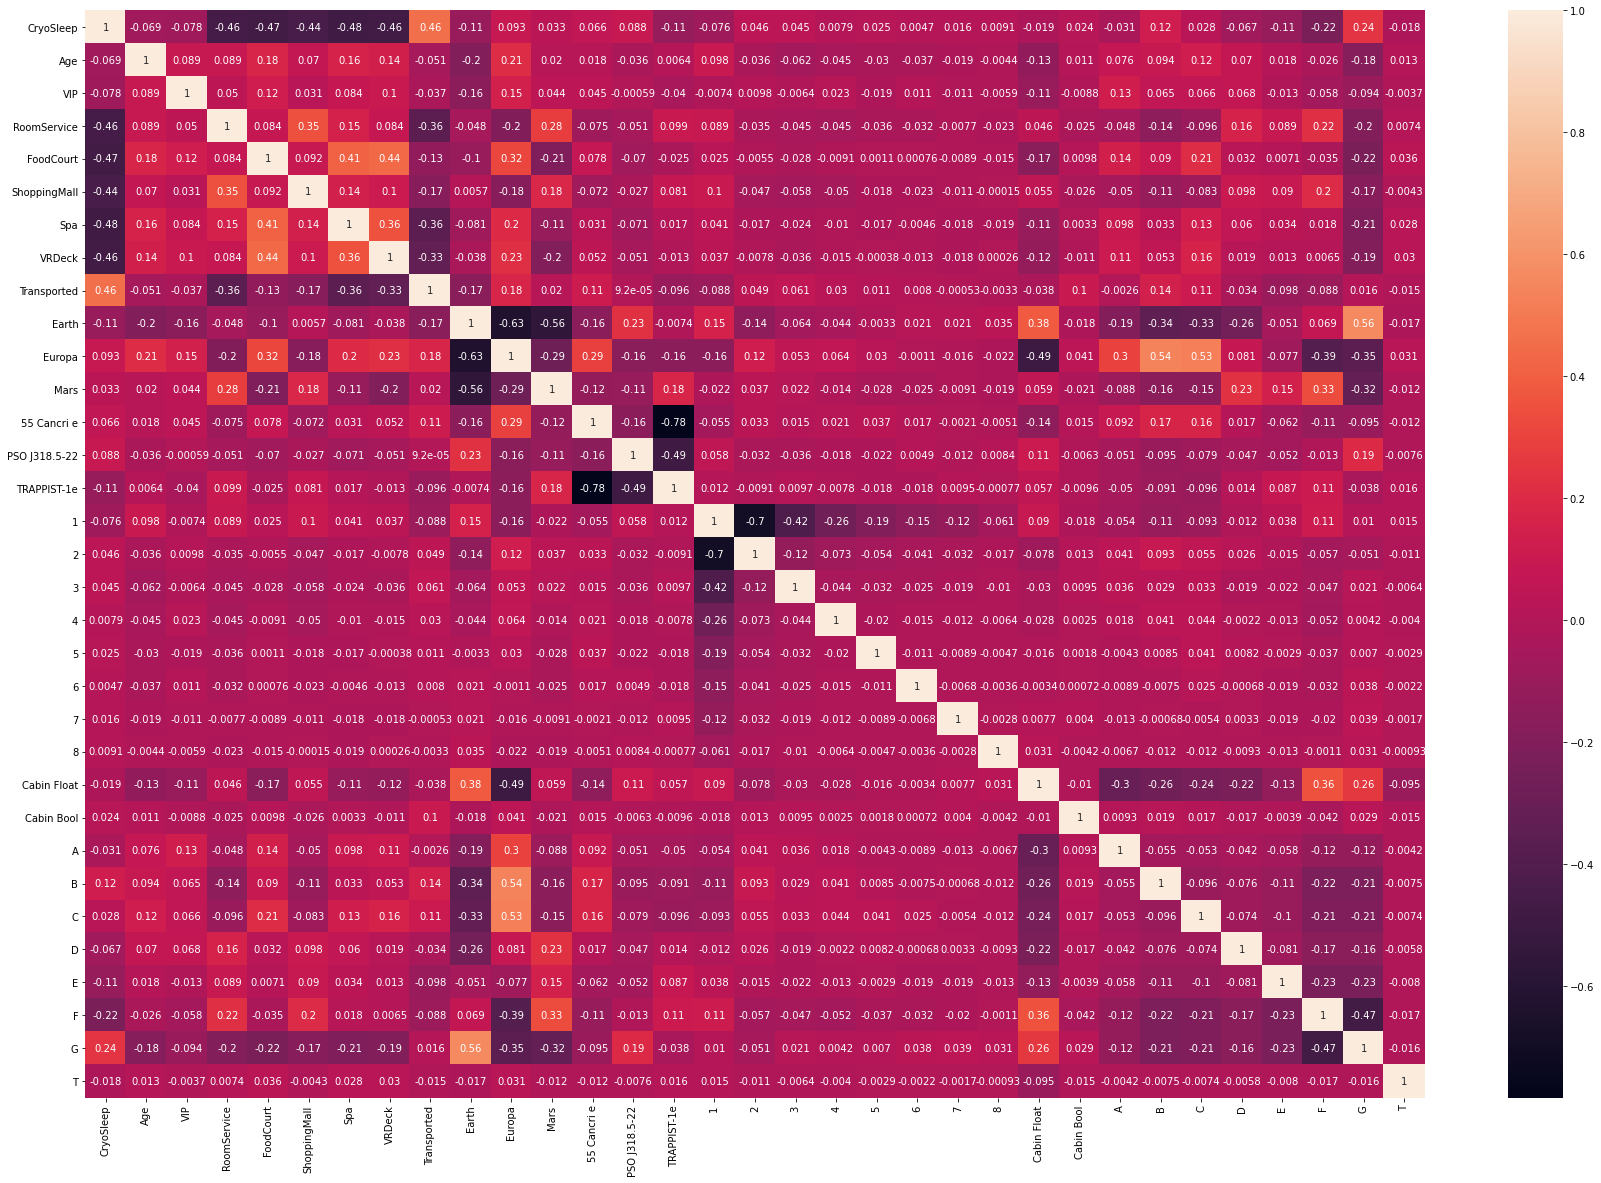

In [247]:
corrMatrix = trainData.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix,annot = True)
plt.show()

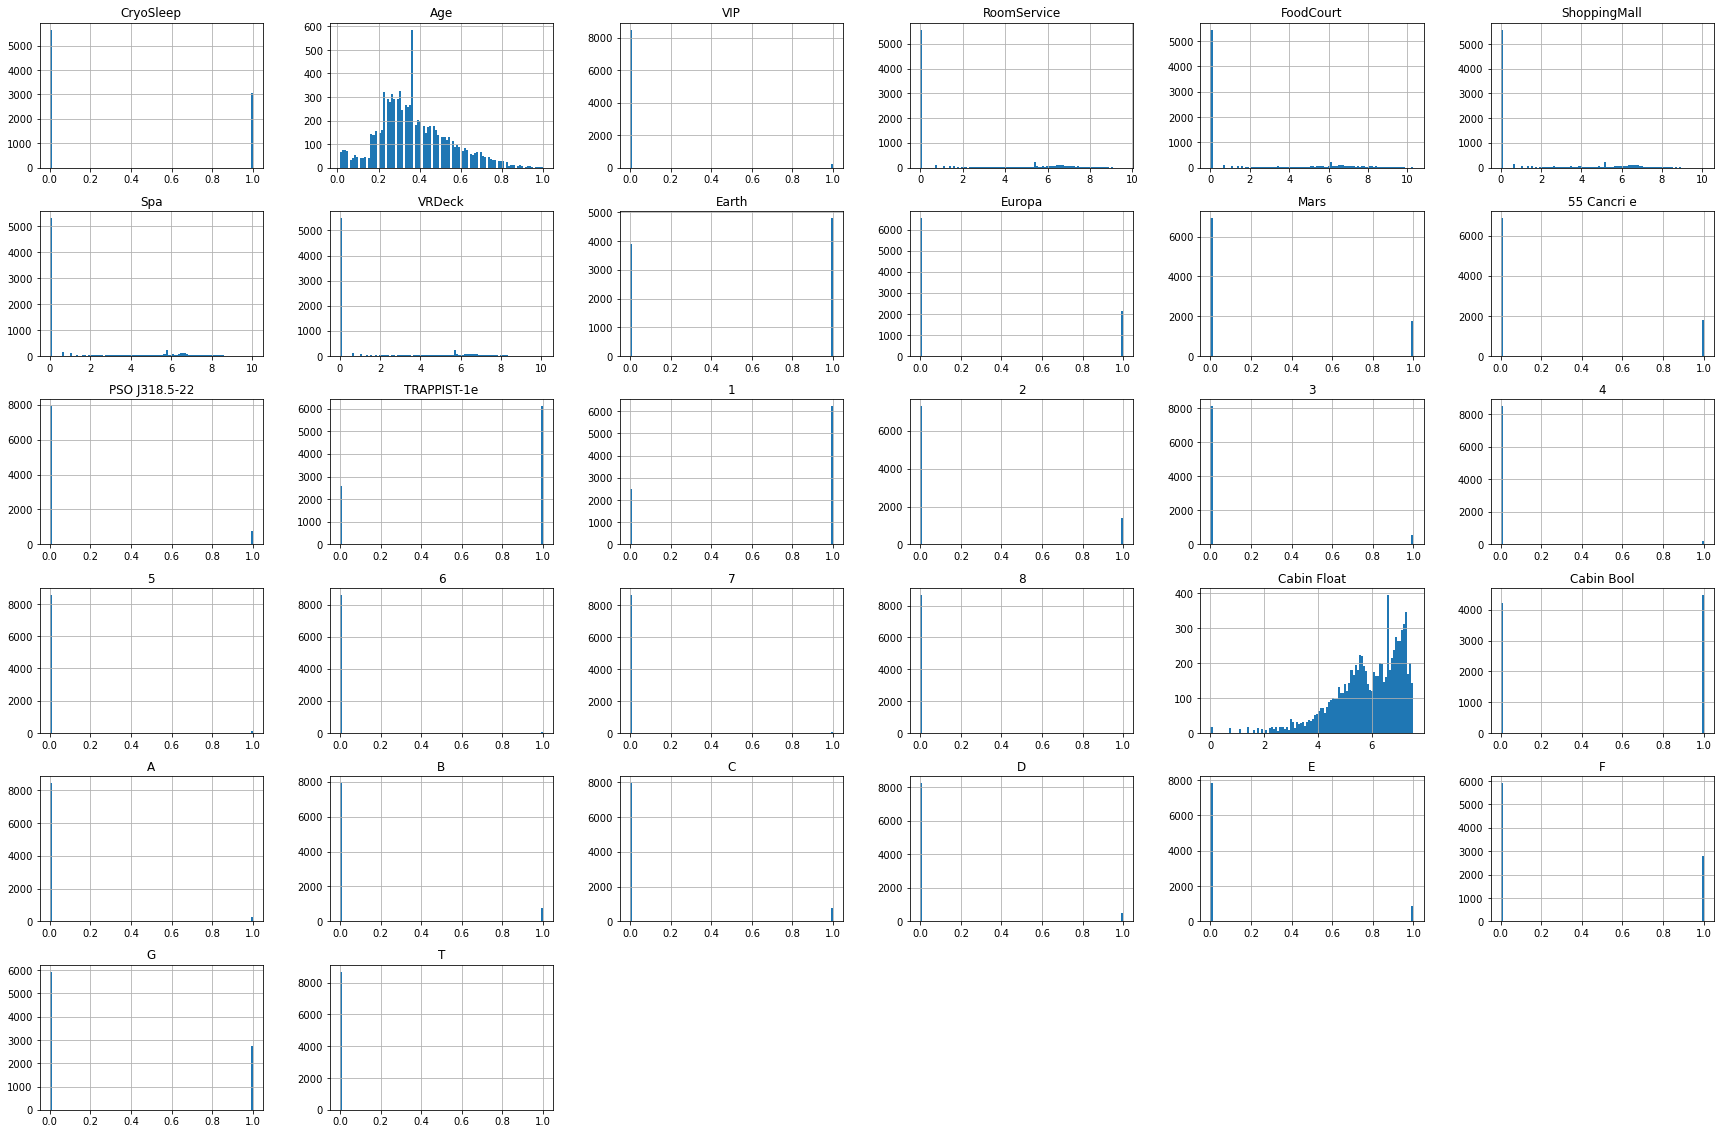

In [248]:
trainData.hist(bins=100,figsize=(30,20))
plt.show()

In [249]:
del trainData["T"]

In [344]:
sample_weights=np.ones((trainData.shape[0]))
sample_weights[np.where(trainData["VIP"]==1)[0]] = 1+((np.where(trainData["VIP"]!=1)[0].shape[0])/8693)

In [345]:
sample_weights

array([1.        , 1.        , 1.97710802, ..., 1.        , 1.        ,
       1.        ])

In [346]:
gBoost = GradientBoostingClassifier(n_estimators=100,max_depth=5,random_state=0,learning_rate=0.1,validation_fraction=0)
rForest= RandomForestClassifier(n_estimators=100,random_state=0,max_depth=5)
lReg = LogisticRegression()

In [347]:
features = trainData.loc[:,trainData.columns!= "Transported"].to_numpy()
targets = trainData.loc[:,"Transported"].to_numpy()

features = (features - np.min(features,axis=0))/(np.max(features,axis=0)-np.min(features,axis=0))

split_ratio=0.8
xTrain = features[:int(features.shape[0]*split_ratio)]
yTrain = targets[:int(features.shape[0]*split_ratio)]

xTest = features[int(features.shape[0]*split_ratio):]
yTest = targets[int(features.shape[0]*split_ratio):]

In [348]:
xTrain.shape,yTrain.shape,xTest.shape,yTest.shape

((6954, 31), (6954,), (1739, 31), (1739,))

In [349]:
gBoost.fit(xTrain,yTrain,sample_weight=sample_weights[:xTrain.shape[0]])
rForest.fit(xTrain,yTrain)
lReg.fit(xTrain,yTrain)

LogisticRegression()

In [350]:
print(gBoost.score(xTest,yTest))
print(rForest.score(xTest,yTest))
print(lReg.score(xTest,yTest))

0.8039102932719954
0.7843588269120184
0.7786083956296722


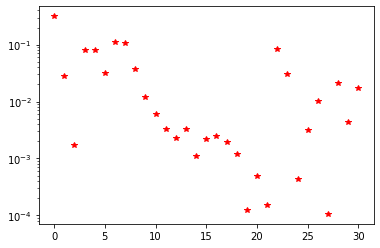

In [334]:
plt.yscale("log")
plt.plot(gBoost.feature_importances_,"r*")
plt.show()

In [187]:
predictions = gBoost.predict(xTest)

In [188]:
submission=pd.read_csv("sample_submission.csv")

In [189]:
submission["Transported"]=predictions

ValueError: Length of values (1739) does not match length of index (4277)

In [83]:
submission.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,2719_03,False
freq,1,2288


In [41]:
submission.to_csv("submission.csv",index=False)